## 07-11 다층 퍼셉트론(MultiLayer Perceptron, MLP)으로 텍스트 분류하기

### 다층 퍼셉트론(MultiLayer Perceptron, MLP)

앞서 단층 퍼셉트론의 형태에서 은닉층이 1개 이상 추가된 신경망을 다층 퍼셉트론(MLP)이라고 한다고 배웠습니다. 다층 퍼셉트론은 피드 포워드 신경망(Feed Forward Neural Network, FFNN)의 가장 기본적인 형태입니다. 피드 포워드 신경망은 입력층에서 출력층으로 오직 한 방향으로만 연산 방향이 정해져 있는 신경망을 말합니다.

뒤에서는 순환 신경망(RNN)과 분산 표현(distributed representation)이라는 새로운 개념들을 사용하여 각종 자연어 처리 실습을 하게 될텐데, 이번 실습의 목적은 위 두 가지 개념없이 지금까지 배운 개념만으로도 자연어 처리를 할 수 있다는 것을 보여주기 위함입니다.

### 케라스의 texts_to_matrix() 이해하기

In [1]:
# 정수 인코딩딩
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer

texts = ['먹고 싶은 사과', '먹고 싶은 바나나', '길고 노란 바나나 바나나', '저는 과일이 좋아요']

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
print(tokenizer.word_index)

{'바나나': 1, '먹고': 2, '싶은': 3, '사과': 4, '길고': 5, '노란': 6, '저는': 7, '과일이': 8, '좋아요': 9}


texts_to_matrix(): 입력된 텍스트 데이터로부터 행렬(matrix)를 만드는 도구입니다. texts_to_matrx()는 총 4개의 모드를 지원하는데 각 모드는 'binary', 'count', 'freq', 'tfidf'로 총 4개입니다.  
다만 주의할 점은 각 단어에 부여되는 인덱스는 1부터 시작하는 반면에 완성되는 행렬의 인덱스는 0부터 시작합니다. 실제로 단어의 개수는 9개였지만 완성된 행렬의 열의 개수는 10개인 것과 첫번째 열은 모든 행에서 값이 0인 것을 볼 수 있습니다. 인덱스 0에는 그 어떤 단어도 할당되지 않았기 때문입니다.

In [2]:
# count 모드: 문서 단어 행렬(Document-Term Matrix, DTM)을 생성
print(tokenizer.texts_to_matrix(texts, mode = 'count')) # texts_to_matrix의 입력으로 texts를 넣고, 모드는 'count'

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 2. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [3]:
# binaray 모드: DTM과 결과와 유사. 해당 단어가 존재하는지만 관심을 가지고 해당 단어가 몇 개였는지는 무시
print(tokenizer.texts_to_matrix(texts, mode = 'binary'))

[[0. 0. 1. 1. 1. 0. 0. 0. 0. 0.]
 [0. 1. 1. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 1. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1. 1.]]


In [4]:
# tfidf 모드: TF-IDF 행렬을 생성. 앞서 배운 기본식과는 살짝 다름
print(tokenizer.texts_to_matrix(texts, mode = 'tfidf').round(2)) # 둘째 자리까지 반올림하여 출력

[[0.   0.   0.85 0.85 1.1  0.   0.   0.   0.   0.  ]
 [0.   0.85 0.85 0.85 0.   0.   0.   0.   0.   0.  ]
 [0.   1.43 0.   0.   0.   1.1  1.1  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   1.1  1.1  1.1 ]]


In [5]:
# freq 모드: 각 문서에서의 각 단어의 등장 횟수를 분자로, 각 문서의 크기(각 문서에서 등장한 모든 단어의 개수의 총 합)를 분모로 하는 표현
print(tokenizer.texts_to_matrix(texts, mode = 'freq').round(2)) # 둘째 자리까지 반올림하여 출력

[[0.   0.   0.33 0.33 0.33 0.   0.   0.   0.   0.  ]
 [0.   0.33 0.33 0.33 0.   0.   0.   0.   0.   0.  ]
 [0.   0.5  0.   0.   0.   0.25 0.25 0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.33 0.33 0.33]]


### 20개 뉴스 그룹(Twenty Newsgroups) 데이터에 대한 이해

이메일 본문을 보고 20개의 주제 중 어떤 주제인지를 맞추는 실습

In [6]:
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical

newsdata = fetch_20newsgroups(subset = 'train') # 'train'을 기재하면 훈련 데이터만 리턴한다.

In [7]:
print('훈련용 샘플의 개수 : {}'.format(len(newsdata.data)))
print('총 주제의 개수 : {}'.format(len(newsdata.target_names)))
print(newsdata.target_names)

훈련용 샘플의 개수 : 11314
총 주제의 개수 : 20
['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']


In [8]:
# 훈련에 사용될 메일 본문인 data와 레이블인 target을 데이터프레임으로 만들어서 데이터에 대한 통계적인 정보들을 알아보겠습니다.
data = pd.DataFrame(newsdata.data, columns = ['email'])
data['target'] = pd.Series(newsdata.target)
data[:5]

,email,target
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14


In [9]:
# news열은 문자열, target열은 정수형 데이터
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11314 entries, 0 to 11313
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   email   11314 non-null  object
 1   target  11314 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 132.7+ KB


In [10]:
#  Null 값을 가진 샘플이 있는지 확인 
data.isnull().values.any()

False

In [11]:
# 샘플 중 중복을 제거한 개수를 확인
print('중복을 제외한 샘플의 수 : {}'.format(data['email'].nunique()))
print('중복을 제외한 주제의 수 : {}'.format(data['target'].nunique()))

중복을 제외한 샘플의 수 : 11314
중복을 제외한 주제의 수 : 20


<AxesSubplot: >

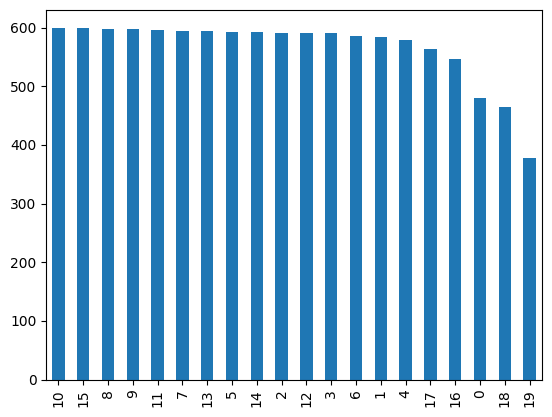

In [12]:
# 레이블 값의 분포를 시각화
data['target'].value_counts().plot(kind='bar')

In [13]:
# 각 레이블이 몇 개 있는지 구체적인 수치로 확인
print(data.groupby('target').size().reset_index(name='count'))

    target  count
0        0    480
1        1    584
2        2    591
3        3    590
4        4    578
5        5    593
6        6    585
7        7    594
8        8    598
9        9    597
10      10    600
11      11    595
12      12    591
13      13    594
14      14    593
15      15    599
16      16    546
17      17    564
18      18    465
19      19    377


In [14]:
# 훈련 데이터와 테스트 데이터가 모두 준비
newsdata_test = fetch_20newsgroups(subset='test', shuffle=True)
train_email = data['email']
train_label = data['target']
test_email = newsdata_test.data
test_label = newsdata_test.target

In [15]:
# vocab_size는 이번 실습에서 사용할 최대 단어 개수를 정의하는 변수입니다. 뒤에서 케라스 토크나이저를 사용하면 빈도수 순으로 인덱스를 부여하므로, 빈도수가 가장 높은 상위 vocab_size 개수만큼의 단어를 사용합니다.
vocab_size = 10000 
num_classes = 20 

def prepare_data(train_data, test_data, mode): # 전처리 함수
    tokenizer = Tokenizer(num_words = vocab_size) # vocab_size 개수만큼의 단어만 사용한다.
    tokenizer.fit_on_texts(train_data)
    X_train = tokenizer.texts_to_matrix(train_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    X_test = tokenizer.texts_to_matrix(test_data, mode=mode) # 샘플 수 × vocab_size 크기의 행렬 생성
    return X_train, X_test, tokenizer.index_word

X_train, X_test, index_to_word = prepare_data(train_email, test_email, 'binary') # binary 모드로 변환
y_train = to_categorical(train_label, num_classes) # 원-핫 인코딩
y_test = to_categorical(test_label, num_classes) # 원-핫 인코딩

In [16]:
# 사실 단어의 정수 인덱스는 1부터 시작하지만, 행렬의 인덱스는 0부터 시작하여 0번 인덱스는 사용되지 않으므로 실제로 행렬에는 빈도수 기준 상위 9,999개의 단어가 표현된 셈입니다. 
print('훈련 샘플 본문의 크기 : {}'.format(X_train.shape))
print('훈련 샘플 레이블의 크기 : {}'.format(y_train.shape))
print('테스트 샘플 본문의 크기 : {}'.format(X_test.shape))
print('테스트 샘플 레이블의 크기 : {}'.format(y_test.shape))

훈련 샘플 본문의 크기 : (11314, 10000)
훈련 샘플 레이블의 크기 : (11314, 20)
테스트 샘플 본문의 크기 : (7532, 10000)
테스트 샘플 레이블의 크기 : (7532, 20)


In [17]:
# 빈도수 상위 1번 단어와 9,999번 단어를 확인해보겠습니다. 불용어에 해당되는 단어 'the'가 빈도수 상위 1번 단어가 된 것을 확인할 수 있습니다.
print('빈도수 상위 1번 단어 : {}'.format(index_to_word[1]))
print('빈도수 상위 9999번 단어 : {}'.format(index_to_word[9999]))

빈도수 상위 1번 단어 : the
빈도수 상위 9999번 단어 : mic


### 다층 퍼셉트론(Multilayer Perceptron, MLP)을 사용하여 텍스트 분류하기

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def fit_and_evaluate(X_train, y_train, X_test, y_test):
    model = Sequential()
    model.add(Dense(256, input_shape=(vocab_size,), activation='relu'))
    model.add(Dropout(0.5)) # 과적합 방지
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5)) # 과적합 방지
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.1)
    score = model.evaluate(X_test, y_test, batch_size=128, verbose=0)
    return score[1]

In [19]:
modes = ['binary', 'count', 'tfidf', 'freq'] # 4개의 모드를 리스트에 저장.

for mode in modes: # 4개의 모드에 대해서 각각 아래의 작업을 반복한다.
    X_train, X_test, _ = prepare_data(train_email, test_email, mode) # 모드에 따라서 데이터를 전처리
    score = fit_and_evaluate(X_train, y_train, X_test, y_test) # 모델을 훈련하고 평가.
    print(mode+' 모드의 테스트 정확도:', score)

Epoch 1/5
80/80 [==============================] - 8s 82ms/step - loss: 2.2818 - accuracy: 0.3384 - val_loss: 0.9584 - val_accuracy: 0.8224
Epoch 2/5
80/80 [==============================] - 6s 79ms/step - loss: 0.8603 - accuracy: 0.7659 - val_loss: 0.4604 - val_accuracy: 0.8843
Epoch 3/5
80/80 [==============================] - 6s 78ms/step - loss: 0.4290 - accuracy: 0.8891 - val_loss: 0.3519 - val_accuracy: 0.8975
Epoch 4/5
80/80 [==============================] - 7s 83ms/step - loss: 0.2570 - accuracy: 0.9336 - val_loss: 0.3163 - val_accuracy: 0.9037
Epoch 5/5
80/80 [==============================] - 6s 79ms/step - loss: 0.1778 - accuracy: 0.9561 - val_loss: 0.2859 - val_accuracy: 0.9081
binary 모드의 테스트 정확도: 0.8279341459274292
Epoch 1/5
80/80 [==============================] - 8s 79ms/step - loss: 2.7835 - accuracy: 0.2479 - val_loss: 1.7002 - val_accuracy: 0.6749
Epoch 2/5
80/80 [==============================] - 6s 77ms/step - loss: 1.4677 - accuracy: 0.6205 - val_loss: 0.7488 - va